In [1]:
!pip install tensorflow
!pip install nltk
!pip install PySastrawi
!pip install spacy==3.6.0

You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

import re
import spacy
#spacy seems no longer support indonesian model. no id tags found on its model releases
#spacy.cli.download("id_core_news_sm")
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
mandiri_review_df = pd.read_csv('livin by mandiri reviews.csv')
mandiri_review_df.head()

,date,review,rating,thumbs_up,version
0,2021-09-30 06:12:53,"Udah di coba, keren dan responsive, dengan tam...",5,36,1.0.0
1,2021-09-30 06:33:15,Excellent,5,0,1.0.0
2,2021-09-30 06:48:30,Keren. Cakep benar semakin canggih. Terdepan t...,5,22,1.0.0
3,2021-09-30 06:56:05,mantap,5,0,NaN
4,2021-09-30 07:02:21,Mantap,5,0,1.0.0


In [3]:
mandiri_review_df['review'].isnull().sum()

0

In [4]:
mandiri_review_df.shape

(155192, 5)

In [5]:
mandiri_review_df.dtypes

date         object
review       object
rating        int64
thumbs_up     int64
version      object
dtype: object

In [6]:
mandiri_review_df['version'].nunique()

10

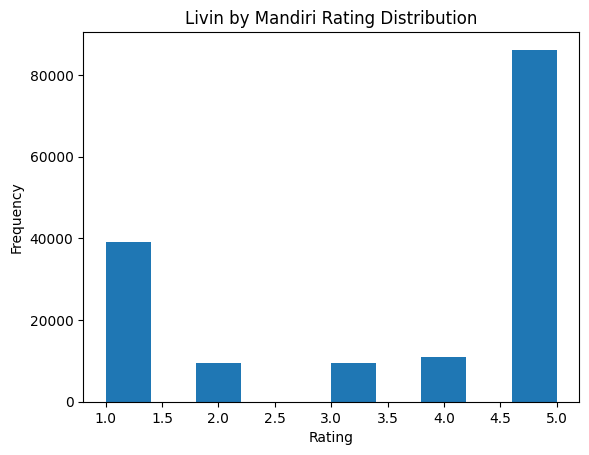

In [7]:
plt.hist(mandiri_review_df['rating'])
plt.title('Livin by Mandiri Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [8]:
#PREPROCESSING
#Clean Punctuation Marks
def clean_punct(review):
    #function to clean a sentence from punctuation marks (',",?,!,(,),:, etc)
    #PARAMETER :
    #review    : string
    #OUTPUT    :
    #clean_review : string
    review = review.lower()
    clean_review = re.sub(r'[^\w\s]', '', review)    
    return clean_review

mandiri_review_df['clean_review'] = mandiri_review_df['review'].apply(clean_punct)
mandiri_review_df.head()

,date,review,rating,thumbs_up,version,clean_review
0,2021-09-30 06:12:53,"Udah di coba, keren dan responsive, dengan tam...",5,36,1.0.0,udah di coba keren dan responsive dengan tampi...
1,2021-09-30 06:33:15,Excellent,5,0,1.0.0,excellent
2,2021-09-30 06:48:30,Keren. Cakep benar semakin canggih. Terdepan t...,5,22,1.0.0,keren cakep benar semakin canggih terdepan ter...
3,2021-09-30 06:56:05,mantap,5,0,NaN,mantap
4,2021-09-30 07:02:21,Mantap,5,0,1.0.0,mantap


In [9]:
#Lemmatization
factory = StemmerFactory()
stemmer = factory.create_stemmer()

mandiri_review_df['lemmatized_review'] = mandiri_review_df['clean_review'].apply(stemmer.stem)
mandiri_review_df[['clean_review','lemmatized_review']]

,clean_review,lemmatized_review
0,udah di coba keren dan responsive dengan tampi...,udah di coba keren dan responsive dengan tampi...
1,excellent,excellent
2,keren cakep benar semakin canggih terdepan ter...,keren cakep benar makin canggih depan percaya ...
3,mantap,mantap
4,mantap,mantap
...,...,...
155187,mantap pokoke,mantap pokoke
155188,sejak di update livin saya susah dibuka setiap...,sejak di update livin saya susah buka tiap kli...
155189,kartu atm saya hilangini bagai mana cara ganti...,kartu atm saya hilangini bagai mana cara ganti...
155190,sudah di donwload tidak berhasil,sudah di donwload tidak hasil


In [10]:
#stopwords removal
#stopwords are words that appear frequently but it doesn't add valuable information to NLP operations and modelling
#stopword removal can have adverse effect if its removal changes the sentence sentiment
#an inspection towards 326 Spacy's stopword shows that most of them are pronouns, adverb of quantity, adverb of position, adverb of time
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

stopwords_list = ['aku', 'kamu', 'itu', 'ini', 'saya', 'makin', 'tambah', 'satu', 'sebuah', '1', 'di', 'pada', 'dan', 'adalah', 'dengan']

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords_list])

mandiri_review_df['nostop_review'] = mandiri_review_df['lemmatized_review'].apply(remove_stopwords)
mandiri_review_df[['lemmatized_review', 'nostop_review']]

,lemmatized_review,nostop_review
0,udah di coba keren dan responsive dengan tampi...,udah coba keren responsive tampil yang segar p...
1,excellent,excellent
2,keren cakep benar makin canggih depan percaya ...,keren cakep benar canggih depan percaya tumbuh...
3,mantap,mantap
4,mantap,mantap
...,...,...
155187,mantap pokoke,mantap pokoke
155188,sejak di update livin saya susah buka tiap kli...,sejak update livin susah buka tiap klik langsu...
155189,kartu atm saya hilangini bagai mana cara ganti...,kartu atm hilangini bagai mana cara ganti kart...
155190,sudah di donwload tidak hasil,sudah donwload tidak hasil


In [11]:
#Tokenization
mandiri_review_df['token_review'] = mandiri_review_df['nostop_review'].apply(word_tokenize)
mandiri_review_df[['nostop_review', 'token_review']]

,nostop_review,token_review
0,udah coba keren responsive tampil yang segar p...,"[udah, coba, keren, responsive, tampil, yang, ..."
1,excellent,[excellent]
2,keren cakep benar canggih depan percaya tumbuh...,"[keren, cakep, benar, canggih, depan, percaya,..."
3,mantap,[mantap]
4,mantap,[mantap]
...,...,...
155187,mantap pokoke,"[mantap, pokoke]"
155188,sejak update livin susah buka tiap klik langsu...,"[sejak, update, livin, susah, buka, tiap, klik..."
155189,kartu atm hilangini bagai mana cara ganti kart...,"[kartu, atm, hilangini, bagai, mana, cara, gan..."
155190,sudah donwload tidak hasil,"[sudah, donwload, tidak, hasil]"


In [12]:
def labeler(star_rating):
    if star_rating < 3:
        result = 'Negative'
    elif star_rating == 3:
        result = 'Normal'
    else:
        result = 'Positive'
    return result

mandiri_review_df['label'] = mandiri_review_df['rating'].apply(labeler)
mandiri_review_df[['rating','label']].head()


,rating,label
0,5,Positive
1,5,Positive
2,5,Positive
3,5,Positive
4,5,Positive


In [13]:
#BagOfWord data representation
bow_vectorizer = CountVectorizer()
#CountVectorizer actually tokenize its input before representing it as a matrix
bow_matrix = bow_vectorizer.fit_transform(mandiri_review_df['nostop_review'])
#extract word feature from vectorizer after fit method
feature_names = bow_vectorizer.get_feature_names_out()
#use sparse matrix as representation
bow_df = pd.DataFrame.sparse.from_spmatrix(bow_matrix, columns = feature_names)
#preserving corresponding sentence-label
bow_df['label'] = mandiri_review_df['label'].values

bow_df.head()

,00,000,0000,00000500,0000amp,0022,0030,0039,0059,008,...,zx,zy,zz,zzz,zzzz,zzzzz,zzzzzz,zzzzzzzz,zzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#TF-IDF data representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(mandiri_review_df['nostop_review'])
featurenames_tfidf = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns = featurenames_tfidf)
tfidf_df['label'] = mandiri_review_df['label'].values
tfidf_df.head()

,00,000,0000,00000500,0000amp,0022,0030,0039,0059,008,...,zx,zy,zz,zzz,zzzz,zzzzz,zzzzzz,zzzzzzzz,zzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Bag of Word are basically unigram
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_matrix = bigram_vectorizer.fit_transform(mandiri_review_df['nostop_review'])
featurenames_bigram = bigram_vectorizer.get_feature_names_out()
bigram_df = pd.DataFrame.sparse.from_spmatrix(bigram_matrix, columns = featurenames_bigram)
bigram_df['label'] = mandiri_review_df['label'].values
bigram_df.head()

,00 96,00 aplikasi,00 atas,00 bntang,00 knapa,00 maintenance,00 pasti,00 sampai,00 sd,00 sering,...,zonkkkkksusah buka,zonkmengecewakan tolong,zonkmungkin bagi,zoom wa,zoom youtube,zoss gandosmantul,zx 77,zzz dll,zzzzzzzz masak,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive


In [16]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_matrix = trigram_vectorizer.fit_transform(mandiri_review_df['nostop_review'])
featurenames_trigram = trigram_vectorizer.get_feature_names_out()
trigram_df = pd.DataFrame.sparse.from_spmatrix(trigram_matrix, columns = featurenames_trigram)
trigram_df['label'] = mandiri_review_df['label'].values
trigram_df.head()
#'I like u now' with rating of 5 and 'I like u nomore' with a rating of 1
#will generate 'I like u' trigram with a rating of 5 and 1 independently

,00 aplikasi inig,00 atas suka,00 bntang nya,00 knapa ngk,00 maintenance ko,00 pasti eror,00 sampai jam,00 sd 01,00 sering gabisa,00 tidak ada,...,zonkenter login aplikasi,zonkkkkkalau mau komplen,zonkkkkkkkecewapadahal sdh dapat,zonkmengecewakan tolong baik,zonkmungkin bagi kalian,zoom wa email,zoom youtube lancar,zzz dll arti,zzzzzzzz masak harus,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive


In [17]:
#Split test and train dataset
y1 = bow_df['label']
X1 = bow_df.drop('label', axis=1)

y2 = bigram_df['label']
X2 = bigram_df.drop('label', axis = 1)

y3 = trigram_df['label']
X3 = trigram_df.drop('label', axis=1)

y4 = tfidf_df['label']
X4 = tfidf_df.drop('label', axis=1)

In [18]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=123)


In [19]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=123)


In [20]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=123)


In [21]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state=123)

In [30]:
def display_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    #fpr is false positive rate, tpr is true positive rate
    #plot roc curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    #lw is linewidth
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    #set x axis range from 0 to 1
    plt.xlim([0.0, 1.0])
    #set y axis range from 0 to 1.05, 1.05 so if we get perfect roc auc we can still see the line
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
#setting hyperparameter tuning for naive bayes
#since the data is discrete, non continuous NB ML model is picked
#regularization is set, but it is predicted will have more effect on unigram, trigram with typos will suffer from regularization
#fit prior set to true[default], so instead making assumption that all word has same probability, some word actually more probable to exist
#class prior set to false [default], since we have no data of probability of certain word

#categoricalNB can only be used if the each feature representation in the data is integer coding of feature existence or absence that represents outcome of y labels
nb_params = {'MultinomialNB' : {'alpha' : [1.0, 5.0, 10.0, 50.0, 100]},
           'ComplementNB'   : {'alpha' : [1.0, 5.0, 10.0, 50.0, 100]}}

svm_params = {
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

best_models = {}

In [32]:
for i, (X_train, X_test, y_train, y_test) in enumerate([(X1_train, X1_test, y1_train, y1_test),
                                                         (X2_train, X2_test, y2_train, y2_test),
                                                         (X3_train, X3_test, y3_train, y3_test),
                                                         (X4_train, X4_test, y4_train, y4_test)]):
    #Naive Bayes
    for nb_name, nb_param_grid in nb_params.items():
        #create instance of nb_name in nb_params
        #cv set to 5 becase more folds need more computational power
        nb_grid = GridSearchCV(eval(nb_name)(), nb_param_grid, cv=5, scoring='accuracy')
        #fit to each instances made
        nb_grid.fit(X_train, y_train)
        best_models[f'{nb_name}_dataset_{i+1}'] = nb_grid.best_estimator_
        print(f"Best {nb_name} parameters for dataset {i+1}: {nb_grid.best_params_}")
        print(f"Best {nb_name} accuracy for dataset {i+1}: {nb_grid.best_score_}")
        y_pred = nb_grid.predict(X_test)
        print(f"Evaluation metrics for {nb_name} on dataset {i+1}:")
        #display_metrics(y_test, y_pred)

    # SVM
    for svm_name, svm_param_grid in svm_params.items():
        svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')
        svm_grid.fit(X_train, y_train)
        best_models[f'{svm_name}_dataset_{i+1}'] = svm_grid.best_estimator_
        print(f"Best {svm_name} parameters for dataset {i+1}: {svm_grid.best_params_}")
        print(f"Best {svm_name} accuracy for dataset {i+1}: {svm_grid.best_score_}")
        y_pred = svm_grid.predict(X_test)
        print(f"Evaluation metrics for {svm_name} on dataset {i+1}:")
        #display_metrics(y_test, y_pred)
    

Best MultinomialNB parameters for dataset 1: {'alpha': 5.0}
Best MultinomialNB accuracy for dataset 1: 0.849838528428009
Evaluation metrics for MultinomialNB on dataset 1:


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].